In [ ]:
from google.colab import files
uploaded = files.upload()

Saving lnu-deep-learn-1-image-classification-2024.zip to lnu-deep-learn-1-image-classification-2024.zip


In [ ]:
import zipfile
import os

zip_file_name = 'lnu-deep-learn-1-image-classification-2024.zip'

extract_folder = 'lnu-deep-learn-1-image-classification-2024'
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install sklearn
!pip install matplotlib
!pip install pycaret
!pip install ipywidgets
!pip3 install --pre --extra-index-url https://developer.download.nvidia.com/compute/redist/jp/v502 tensorflow==2.10.0+nv22.10
!pip install protobuf

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D

import numpy as np
import pandas as pd
import os
import sys

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import sklearn as sk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_augmentation(augmented_data, generator, directory, class_names, n_images=7):

    batch = next(augmented_data)
    images, labels = batch

    plt.figure(figsize=(10, 5))
    for i in range(n_images):
        plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Original\nClass: {class_names[np.argmax(labels[i])]}", fontsize=6)
        plt.axis('off')

    augmented_batch = (images, labels)
    augmented_iterator = generator.flow(augmented_batch, batch_size=n_images)

    augmented_images, augmented_labels = next(augmented_iterator)

    for i in range(n_images):
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(image.array_to_img(augmented_images[i]))
        plt.title(f"Augmented\nClass: {class_names[np.argmax(augmented_labels[i])]}", fontsize=6)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def preprocess_data(X, y):
    # препроцесинг для підготовки формату, необхідного моделі
    X = preprocess_input(X)
    # текст у список ідекс - слово
    y = tf.one_hot(y, 100)
    return X, y

In [ ]:
base_dir = '/content/lnu-deep-learn-1-image-classification-2024'

with open(os.path.join(base_dir, 'classes.txt'), 'r') as f:
    class_names = [line.strip() for line in f]
print(f"Завантажено {len(class_names)} класів.")


Завантажено 100 класів.


In [ ]:
img_size = (224, 224)
batch_size = 32
number_of_epochs = 15
learning_rate = 0.0001

image_datagenerator = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 50,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True ,
                    vertical_flip = True ,
                    fill_mode = 'nearest',
                    validation_split = 0.35)


train_generator = image_datagenerator.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        subset='training')

validation_generator = image_datagenerator.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Found 7139 images belonging to 100 classes.
Found 3772 images belonging to 100 classes.


In [ ]:
(train_dataset,val_dataset)= tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    shuffle = True,
    image_size = img_size ,
    batch_size = 32,
    subset = "both",
    validation_split = 0.30,
    seed = 123
    )

Found 10911 files belonging to 100 classes.
Using 7638 files for training.
Using 3273 files for validation.


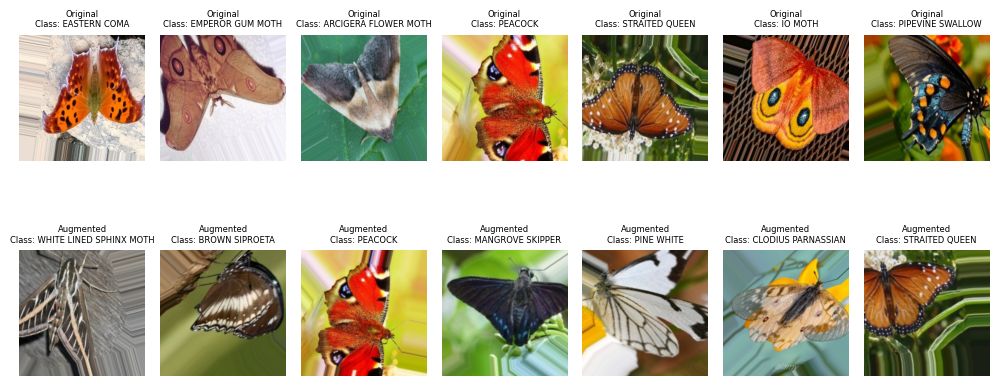

In [ ]:
plot_augmentation(train_generator, image_datagenerator, 'train', class_names)

In [ ]:
data_frame = pd.read_csv(os.path.join(base_dir, 'train.csv'))
# кількість прикладів у кожному класі
label_numbers = data_frame['label'].value_counts().to_dict()
# представлення назви класу числом - ID
label_dict = {label: idx for idx, label in enumerate(label_numbers.keys())}
label_dict_rev = {new_label: orig_label for orig_label, new_label in label_dict.items()}

<ipython-input-16-3ea105ff58e2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Number of images', y = 'Label', data=df, palette='viridis')


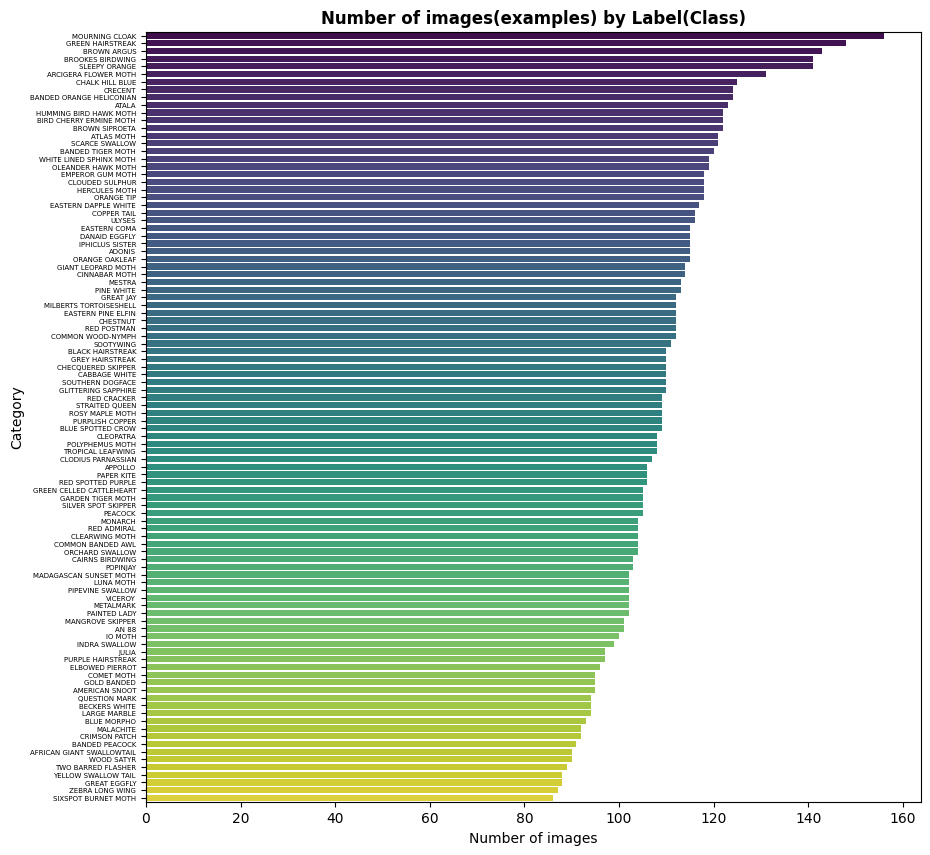

In [ ]:
plt.figure(figsize = (10, 10))

df = pd.DataFrame(list(label_numbers.items()), columns=['Label', 'Number of images'])
sns.barplot(x = 'Number of images', y = 'Label', data=df, palette='viridis')

plt.title('Number of images(examples) by Label(Class)', fontweight='bold')
plt.yticks(fontsize=5)
plt.ylabel("Category");

In [ ]:
resnet_model = ResNet50(include_top=False, weights="imagenet")
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
res = tf.keras.layers.Dense(100, activation="softmax")(x)

model_res = Model(inputs=resnet_model.input, outputs=res)

for layer in resnet_model.layers[:143]:
    layer.trainable = False
for layer in resnet_model.layers[143:]:
    layer.trainable = True

model_res.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
def augment_class_data(generator, class_name, base_dir, target_size, batch_size, num_augmentations):
    class_dir = os.path.join(base_dir, class_name)
    if not os.path.exists(class_dir) or len(os.listdir(class_dir)) == 0:
        print(f"Warning: Directory {class_dir} is empty or does not exist.")
        return np.array([])

    class_generator = generator.flow_from_directory(
        directory=base_dir,
        target_size=target_size,
        batch_size=batch_size,
        classes=[class_name],
        class_mode=None,
        shuffle=True
    )
    augmented_images = []
    for _ in range(num_augmentations):
        img = next(class_generator)
        if len(img) > 0:
            augmented_images.append(img[0])
    return np.array(augmented_images)

augmented_great_marble = augment_class_data(image_datagenerator, "LARGE MARBLE", base_dir=os.path.join(base_dir, 'train'), target_size=(224, 224), batch_size=1, num_augmentations=100)
augmented_great_jay = augment_class_data(image_datagenerator, "GREAT JAY", base_dir=os.path.join(base_dir, 'train'), target_size=(224, 224), batch_size=1, num_augmentations=100)
augmented_garden_tiger_moth = augment_class_data(image_datagenerator, "GARDEN TIGER MOTH", base_dir=os.path.join(base_dir, 'train'), target_size=(224, 224), batch_size=1, num_augmentations=100)


Found 94 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 105 images belonging to 1 classes.


In [ ]:
hist_res = model_res.fit(
      train_dataset,
      epochs=number_of_epochs,
      validation_data=val_dataset,
      verbose=1,
      callbacks=[reduce_lr]
).history

Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 85s 248ms/step - accuracy: 0.0811 - loss: 4.4181 - val_accuracy: 0.7082 - val_loss: 1.2690 - learning_rate: 1.0000e-04
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 143ms/step - accuracy: 0.5847 - loss: 1.7196 - val_accuracy: 0.8735 - val_loss: 0.5128 - learning_rate: 1.0000e-04
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.8169 - loss: 0.6919 - val_accuracy: 0.8958 - val_loss: 0.3964 - learning_rate: 1.0000e-04
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.9039 - loss: 0.3789 - val_accuracy: 0.8946 - val_loss: 0.4370 - learning_rate: 1.0000e-04
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.9415 - loss: 0.2436 - val_accuracy: 0.9172 - val_loss: 0.3644 - learning_rate: 1.0000e-04
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.9669 - loss: 0.1342 - val_accuracy: 0.9056 - val_loss: 0.4501 - learning_rate: 1.0000e-04
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 14

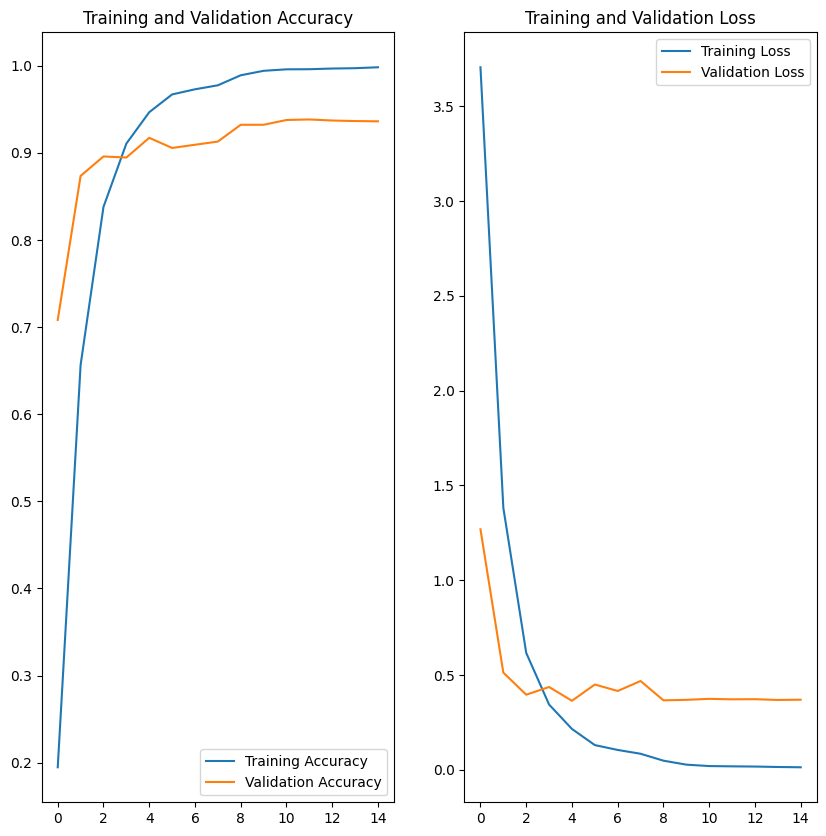

In [ ]:
accuracy_res = hist_res['accuracy']
validation_accuracy_res= hist_res['val_accuracy']

loss_res = hist_res['loss']
validation_loss_res = hist_res['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(number_of_epochs), accuracy_res, label='Training Accuracy')
plt.plot(range(number_of_epochs), validation_accuracy_res, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(number_of_epochs), loss_res, label='Training Loss')
plt.plot(range(number_of_epochs), validation_loss_res, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions_resnet = model_res.predict(val_dataset)

y_pred_resnet = np.argmax(predictions_resnet, axis = 1)

y_true_resnet = np.concatenate([y for x, y in val_dataset], axis=0)

class_report_resnet = classification_report(y_true_resnet, y_pred_resnet, target_names = class_names)
print("Classification Report (ResNet50):")
print(class_report_resnet)

103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step
Classification Report (ResNet50):
                           precision    recall  f1-score   support

                   ADONIS       0.84      0.84      0.84        37
AFRICAN GIANT SWALLOWTAIL       0.96      0.93      0.94        27
           AMERICAN SNOOT       1.00      0.96      0.98        25
                    AN 88       1.00      1.00      1.00        27
                  APPOLLO       0.95      1.00      0.97        35
     ARCIGERA FLOWER MOTH       0.92      0.97      0.94        34
                    ATALA       1.00      1.00      1.00        41
               ATLAS MOTH       0.91      0.97      0.94        33
 BANDED ORANGE HELICONIAN       0.91      0.94      0.92        31
           BANDED PEACOCK       0.95      0.90      0.92        20
        BANDED TIGER MOTH       0.87      0.89      0.88        37
            BECKERS WHITE       0.97      1.00      0.98        30
  BIRD CHERRY ERMINE MOTH       0.97      0.97    

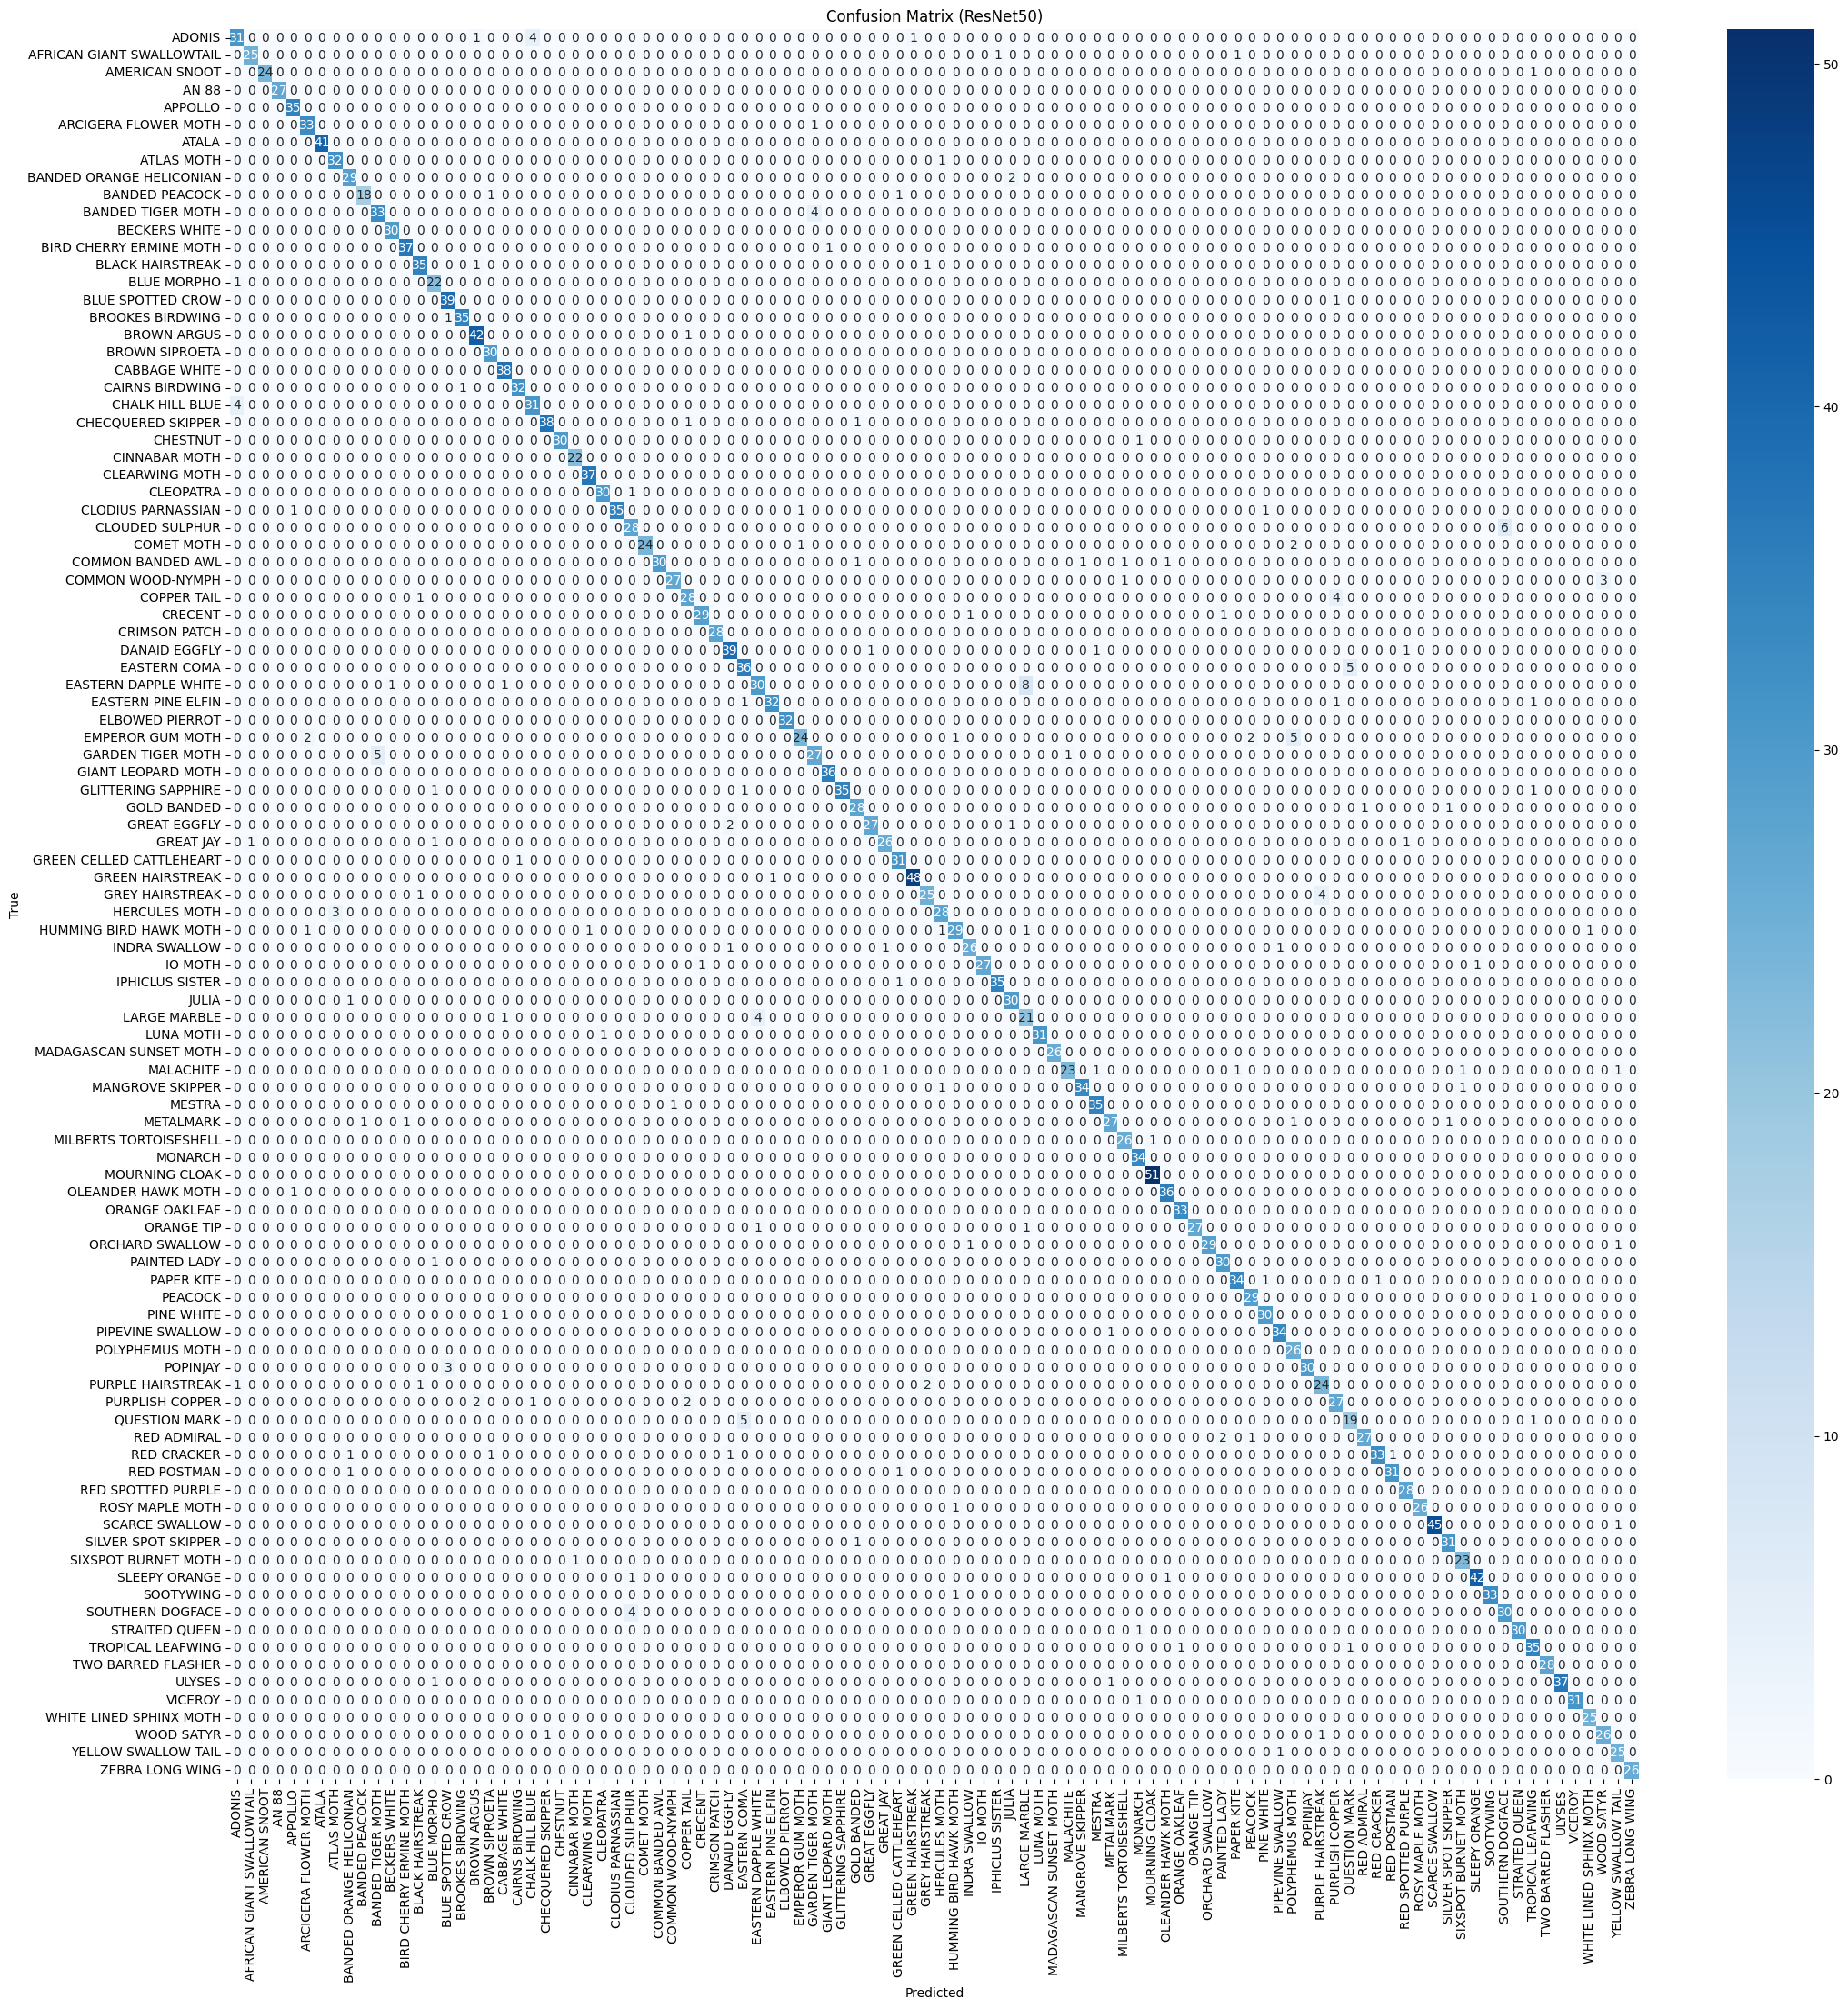

In [ ]:
plt.figure(figsize=(25, 25))
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ResNet50)')
plt.show()

In [ ]:
test = pd.read_csv('lnu-deep-learn-1-image-classification-2024/test.csv')
test.head()
paths = test['path']
classes = []
for path in paths:
    img = tf.keras.preprocessing.image.load_img(f'lnu-deep-learn-1-image-classification-2024/{path}', target_size=(224, 224))
    img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)
    score = model_res.predict(img_array)
    classes.append(class_names[np.argmax(score)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

In [24]:
test['label'] = classes
test.drop(columns = 'path', axis = 1, inplace = True)
test.head()

,id,label
0,4cfe706486ee4561a89188090f52b9c6,RED ADMIRAL
1,2874a810e78844ccbedfb4ae5e54b88a,BROOKES BIRDWING
2,8dd78fedc88644e6baba3642d57049af,STRAITED QUEEN
3,c1022ebd1c564bc88b4515e1f9216ab3,ORANGE TIP
4,19d87765acbd438bbf1b7cec8ff4fe16,MALACHITE


In [25]:
test.to_csv('results_ind_task_1.csv',index = False)